# Analysing cumulative precipitation vs altitude (DTM)
In this section, will analyze the cumilative precipitation vs altitude of all the station located in 13 counties of interest. There are 44 precipitation stations in the region and time of interest. The required station has been extract to use in the analysis. The comperisaon between the altitude of station meta data and the altitude from DTM will be executed.


## FTP Connection

### Connection Parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [2]:
# The topic of interest.
topic_dir = "/hourly/precipitation/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [3]:
local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallelly merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/
../data/original/DWD//hourly/precipitation/historical/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/
../data/generated/DWD//hourly/precipitation/historical/


In [4]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True) # it does not complain if the dir already exists. # it does not complain if the dir already exists.
os.makedirs(local_ftp_ts_dir,exist_ok = True) # it does not complain if the dir already exists.

os.makedirs(local_generated_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_station_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ts_merged_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ts_appended_dir,exist_ok = True) # it does not complain if the dir already exists.

### FTP Connect

In [5]:
import ftplib
ftp = ftplib.FTP(server)
response = ftp.login(user=user, passwd = passwd)
print(response)

230 Login successful.


In [6]:
ret = ftp.cwd(".")

### FTP Grab File Function

In [7]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [8]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [9]:
# Generate a pandas dataframe from the FTP directory listing 
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [10]:
df_ftpdir.head(10)

,station_id,name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_hourly_precipi...,.pdf,166317,-
1,-1,DESCRIPTION_obsgermany_climate_hourly_precipit...,.pdf,161348,-
2,-1,RR_Stundenwerte_Beschreibung_Stationen.txt,.txt,303009,-
3,3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
4,20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
5,44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
6,53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
7,71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
8,73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
9,78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-


### Dataframe with TS Zip Files

In [11]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-
91,stundenwerte_RR_00091_20040901_20201231_hist.zip,.zip,419182,-


### Download the Station Description File

In [12]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)



RR_Stundenwerte_Beschreibung_Stationen.txt


In [13]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt


In [14]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [15]:
basename = os.path.splitext(station_fname)[0]
dataframe_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
dataframe_stations.head(5)

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-03-26,432,48.9219,9.9129,Abtsgm�nd-Untergr�ningen,Baden-W�rttemberg
29,2006-01-10,2022-03-26,260,49.7175,10.9101,Adelsdorf (Kl�ranlage),Bayern
44,2007-04-01,2022-03-26,44,52.9336,8.2370,Gro�enkneten,Niedersachsen
46,2006-01-03,2022-03-26,325,48.9450,12.4639,Aholfing,Bayern


In [16]:
dataframe_stations

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-03-26,432,48.9219,9.9129,Abtsgm�nd-Untergr�ningen,Baden-W�rttemberg
29,2006-01-10,2022-03-26,260,49.7175,10.9101,Adelsdorf (Kl�ranlage),Bayern
44,2007-04-01,2022-03-26,44,52.9336,8.2370,Gro�enkneten,Niedersachsen
46,2006-01-03,2022-03-26,325,48.9450,12.4639,Aholfing,Bayern
...,...,...,...,...,...,...,...
19319,2021-11-01,2022-03-26,340,50.2891,7.0888,Anschau,Rheinland-Pfalz
19361,2021-10-29,2022-03-26,540,50.4159,11.0437,Frankenblick-Rauenstein,Th�ringen
19362,2021-10-29,2022-03-26,720,50.4602,11.0858,Neuhaus-Steinheid (Th�r.),Th�ringen


### Select Stations Located in NRW from Station Description Dataframe

In [17]:
station_ids_selected = dataframe_stations[dataframe_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,   216,   326,   389,   390,   554,   555,   599,   603,
              613,
            ...
            14179, 14180, 14181, 14182, 14183, 14184, 14185, 14186, 14187,
            15000],
           dtype='int64', name='station_id', length=158)

# Station id filtering

In [18]:
# Create variable with TRUE if state is Nordrhein-Westfalen
import datetime
isNRW = dataframe_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = dataframe_stations['date_to'] >= datetime.datetime(2018, 1, 1)

#isBefore1950 = df_stations['date_from'] < '1950'
#dfNRW = df_stations[isNRW & isOperational & isBefore1950]

# select on both conditions

#dfNRW = df_stations[isNRW & isOperational]
dataframe_NRW = dataframe_stations[isNRW]
#print("Number of stations in NRW: \n", dfNRW.count())
dataframe_NRW

fltr=(dataframe_NRW.index== 216 )| (dataframe_NRW.index == 389) | (dataframe_NRW.index == 390)|(dataframe_NRW.index == 613)|(dataframe_NRW.index == 644)|(dataframe_NRW.index == 796)|(dataframe_NRW.index == 934)|(dataframe_NRW.index == 1300 )|(dataframe_NRW.index == 2483)|(dataframe_NRW.index == 2947)|(dataframe_NRW.index == 3028)|(dataframe_NRW.index == 3031)|(dataframe_NRW.index == 3098 )|(dataframe_NRW.index == 3215)|(dataframe_NRW.index == 3499)|(dataframe_NRW.index == 4127)|(dataframe_NRW.index == 4313)|(dataframe_NRW.index == 4368 )|(dataframe_NRW.index == 4400)|(dataframe_NRW.index == 4488)|(dataframe_NRW.index == 4692) |(dataframe_NRW.index == 5347 ) |(dataframe_NRW.index == 5360)|(dataframe_NRW.index == 5468)|(dataframe_NRW.index == 5480)| (dataframe_NRW.index == 5619)|(dataframe_NRW.index == 5699 )|(dataframe_NRW.index == 6264)|(dataframe_NRW.index == 6276)|(dataframe_NRW.index == 6313)|(dataframe_NRW.index == 7330)|(dataframe_NRW.index == 13700)|(dataframe_NRW.index == 13713)|(dataframe_NRW.index== 14143)| (dataframe_NRW.index == 14145) | (dataframe_NRW.index == 14170)|(dataframe_NRW.index == 14171)|(dataframe_NRW.index == 14172)|(dataframe_NRW.index == 14173)|(dataframe_NRW.index == 14182)|(dataframe_NRW.index == 14183 )|(dataframe_NRW.index == 14185)|(dataframe_NRW.index == 14186)|(dataframe_NRW.index == 14187)
dataframe_NRW=dataframe_NRW[fltr]
dataframe_NRW.count()

date_from    44
date_to      44
altitude     44
latitude     44
longitude    44
name         44
state        44
dtype: int64

In [19]:
print(df_zips)

                                                        name   ext    size  \
station_id                                                                   
3           stundenwerte_RR_00003_19950901_20110401_hist.zip  .zip  419296   
20          stundenwerte_RR_00020_20040814_20201231_hist.zip  .zip  432124   
44          stundenwerte_RR_00044_20070401_20201231_hist.zip  .zip  354983   
53          stundenwerte_RR_00053_20051001_20201231_hist.zip  .zip  385830   
71          stundenwerte_RR_00071_20041022_20200101_hist.zip  .zip  402875   
...                                                      ...   ...     ...   
15555       stundenwerte_RR_15555_20160501_20201231_hist.zip  .zip  120197   
15810       stundenwerte_RR_15810_20180601_20201231_hist.zip  .zip   69532   
19140       stundenwerte_RR_19140_20201101_20201231_hist.zip  .zip    9708   
19171       stundenwerte_RR_19171_20200901_20201231_hist.zip  .zip   12514   
19172       stundenwerte_RR_19172_20200901_20201231_hist.zip  .z

### Download TS Data from FTP Server
 

In [20]:
#dataframe_NRW.index

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! FTP directory can not analize 11 satation from the ftp server of interested area. Based on the finding, rest of the code execute with 33 staion.  

In [21]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_interested  = list(dataframe_NRW.index)
#print(station_ids_interested)
for station_id in station_ids_interested:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00216_20041001_20201231_hist.zip
stundenwerte_RR_00389_20091101_20201231_hist.zip
stundenwerte_RR_00390_20040701_20201231_hist.zip
stundenwerte_RR_00613_20041101_20201231_hist.zip
stundenwerte_RR_00644_20050101_20201231_hist.zip
stundenwerte_RR_00796_20041101_20201231_hist.zip
stundenwerte_RR_00934_20041001_20201231_hist.zip
stundenwerte_RR_01300_20040601_20201231_hist.zip
stundenwerte_RR_02483_19951012_20201231_hist.zip
stundenwerte_RR_02947_20061001_20201231_hist.zip
stundenwerte_RR_03028_19950901_20201231_hist.zip
stundenwerte_RR_03031_20040701_20201231_hist.zip
stundenwerte_RR_03098_19950901_20201231_hist.zip
stundenwerte_RR_03215_20070601_20201231_hist.zip
stundenwerte_RR_03499_20060701_20201231_hist.zip
stundenwerte_RR_04127_20050101_20201231_hist.zip
stundenwerte_RR_04313_20040801_20201231_hist.zip
stundenwerte_RR_04368_20041001_20201231_hist.zip
stundenwerte_RR_04400_20040801_20201231_hist.zip
stundenwerte_RR_04488_20060801_20201231_hist.zip
stundenwerte_RR_0469

### Join (Merge) the Time Series Columns


In [22]:
from datetime import datetime

def prec_ts_to_df(fname):   # creating a function (prec_ts_to_df)
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]
    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    # .str method used
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [23]:
from datetime import datetime

def temp_ts_to_df(fname):  # creating a function (temp_ts_to_df)
    
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d') for d in dates]
    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM_BEGINN", parse_dates = ["MESS_DATUM_BEGINN"], date_parser = dateparse, na_values = [-999.0, -999])

    # .str method used
    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [24]:
from zipfile import ZipFile

### PRECIPITATION

In [25]:
def prec_ts_merge():      # creating a function (prec_ts_merge)
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')


    df.index.rename(name = "time", inplace = True)
    return(df)

In [26]:
df_merged_ts = prec_ts_merge()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00613_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_00613.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00644_20050101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050101_20201231_00644.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [27]:
df_merged_ts.shape

(221994, 33)

In [28]:
filepathname = local_ts_merged_dir + "prec_ts_merged.csv"
print("df_merged_ts is saved to: %s" % (filepathname))
df_merged_ts.to_csv(filepathname,sep=";")

df_merged_ts is saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged.csv


In [29]:
df_merged_ts_transposed = df_merged_ts.transpose()
df_merged_ts_transposed.index.names = ['station_id']
df_merged_ts_transposed.shape

(33, 221994)

In [30]:
filepathname = local_ts_merged_dir + "prec_ts_merged_transposed.csv"
print("df_merged_ts_transposed is saved to: %s" % (filepathname))
df_merged_ts_transposed.to_csv(filepathname,sep=";")

df_merged_ts_transposed is saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_merged_transposed.csv


In [31]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
# TEMPERATURE                dftmp = temp_ts_to_df(myfile)
# PRECIPIATION
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(dataframe_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)

    return(df)

In [32]:
df_appended_ts = ts_append()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00389_20091101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20091101_20201231_00389.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00390_20040701_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040701_20201231_00390.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00613_20041101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041101_20201231_00613.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenwerte_RR_00644_20050101_20201231_hist.zip
Extract product file: produkt_rr_stunde_20050101_20201231_00644.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/stundenw

In [33]:
df_appended_ts.tail()

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2020-12-31 19:00:00,13713,3,0.0,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 21:00:00,13713,3,0.1,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 22:00:00,13713,3,0.0,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 23:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [34]:
filepathname = local_ts_appended_dir + "prec_ts_appended.csv"
print("df_appended_ts saved to: %s" % (filepathname))
df_appended_ts.to_csv(filepathname,sep=";")

df_appended_ts saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_appended.csv


In [35]:
type(df_appended_ts.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [36]:
type(df_appended_ts.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [37]:
df_appended_ts

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,13713,3,0.0,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 21:00:00,13713,3,0.1,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


This <b>df_appended_ts</b> contains the final data of precipitation of all the requiured stations. Here, the goal is to compare cumulative precipitaton and altitude. The data of altitude of all station is present in <b> stations_dataframe </b>. Let's explore that dataframe before merging. 

# Setting the date filter

In [38]:
idx = (df_appended_ts.index >= '2018-04-16 00:00:00') & (df_appended_ts.index < '2018-08-16 01:00:00') 

In [39]:
df_appended_ts[idx].tail()
df_appended_ts

,stations_id,qn_8,r1,rs_ind,wrtr,eor,date_from,date_to,altitude,latitude,longitude,name,state
mess_datum,,,,,,,,,,,,,
2004-10-01 00:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 01:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 02:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 03:00:00,216,1,0.0,0.0,NaN,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
2004-10-01 04:00:00,216,1,0.0,0.0,0.0,eor,2004-10-01,2022-03-26,298,51.1143,7.8807,Attendorn-Neulisternohl,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,13713,3,0.0,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 20:00:00,13713,3,0.0,0.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen
2020-12-31 21:00:00,13713,3,0.1,1.0,NaN,eor,2007-11-01,2022-03-26,386,51.0899,7.6289,Meinerzhagen-Redlendorf,Nordrhein-Westfalen


In [40]:

df_appended_ts_ex5 = df_appended_ts[idx][["stations_id","r1","date_from","date_to","altitude","latitude","longitude"]]
df_appended_ts_ex5

,stations_id,r1,date_from,date_to,altitude,latitude,longitude
mess_datum,,,,,,,
2018-04-16 00:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 01:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 02:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 03:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 04:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
...,...,...,...,...,...,...,...
2018-08-15 20:00:00,13713,0.0,2007-11-01,2022-03-26,386,51.0899,7.6289
2018-08-15 21:00:00,13713,0.0,2007-11-01,2022-03-26,386,51.0899,7.6289
2018-08-15 22:00:00,13713,0.0,2007-11-01,2022-03-26,386,51.0899,7.6289


In [41]:
filepathname = local_ts_appended_dir + "prec_ts_appended_ex5.csv"
print("df_appended_ts_ex5 saved to: %s" % (filepathname))
df_appended_ts_ex5.to_csv(filepathname,sep=";")

df_appended_ts_ex5 saved to: ../data/generated/DWD//hourly/precipitation/historical/prec_ts_appended_ex5.csv


In [42]:
df_appended_ts_ex5.index

DatetimeIndex(['2018-04-16 00:00:00', '2018-04-16 01:00:00',
               '2018-04-16 02:00:00', '2018-04-16 03:00:00',
               '2018-04-16 04:00:00', '2018-04-16 05:00:00',
               '2018-04-16 06:00:00', '2018-04-16 07:00:00',
               '2018-04-16 08:00:00', '2018-04-16 09:00:00',
               ...
               '2018-08-15 15:00:00', '2018-08-15 16:00:00',
               '2018-08-15 17:00:00', '2018-08-15 18:00:00',
               '2018-08-15 19:00:00', '2018-08-15 20:00:00',
               '2018-08-15 21:00:00', '2018-08-15 22:00:00',
               '2018-08-15 23:00:00', '2018-08-16 00:00:00'],
              dtype='datetime64[ns]', name='mess_datum', length=96233, freq=None)

In [43]:
df_appended_ts_ex5

,stations_id,r1,date_from,date_to,altitude,latitude,longitude
mess_datum,,,,,,,
2018-04-16 00:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 01:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 02:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 03:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
2018-04-16 04:00:00,216,0.0,2004-10-01,2022-03-26,298,51.1143,7.8807
...,...,...,...,...,...,...,...
2018-08-15 20:00:00,13713,0.0,2007-11-01,2022-03-26,386,51.0899,7.6289
2018-08-15 21:00:00,13713,0.0,2007-11-01,2022-03-26,386,51.0899,7.6289
2018-08-15 22:00:00,13713,0.0,2007-11-01,2022-03-26,386,51.0899,7.6289


# Hourly precipitation rate to daily rate.

In [44]:
exercise5 = df_appended_ts_ex5.groupby(['mess_datum','stations_id','altitude','longitude','latitude',])['r1'].sum().to_frame(name = 'daily_precp').reset_index()
cumilativeprecp = exercise5.groupby(['stations_id','longitude','latitude','altitude'])['daily_precp'].sum().to_frame(name = 'monthly_precp').reset_index()
cumilativeprecp

filepathname = local_ts_appended_dir + "monthly_precp.csv"
print(" saved to: %s" % (filepathname))
cumilativeprecp.to_csv(filepathname,sep=";")
cumilativeprecp

 saved to: ../data/generated/DWD//hourly/precipitation/historical/monthly_precp.csv


,stations_id,longitude,latitude,altitude,monthly_precp
0,216,7.8807,51.1143,298,273.7
1,389,8.4318,51.0148,436,175.6
2,390,8.3683,50.9837,610,179.2
3,613,9.2324,51.5677,206,130.1
4,644,9.1738,51.7049,150,115.0
5,796,8.1257,50.7556,412,168.0
6,934,8.5658,51.7835,88,116.8
7,1300,8.1565,51.2540,351,201.8
8,2483,8.4891,51.1803,839,222.2
9,2947,8.0348,51.1333,286,291.1


# Cumulative precipitation vs Altitude plot

In [66]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(dpi= 1000,figsize=(14,6))
plt.style.use('ggplot')
w= 0.4
x = np.arange(len(cumilativeprecp['stations_id']))

plt.bar(x,cumilativeprecp['monthly_precp'],w,color='#D05F12')


plt.xlabel('Altitude (meters)',color='black')
plt.ylabel('Cumulative Precipitation (mm)',color='black')
plt.title('Cumulative Precipitation vs Altitude',color='black')
plt.xticks(x,cumilativeprecp['altitude'],rotation=45,color='black')
plt.yticks(color='black')
plt.show()

fig.savefig(local_station_dir + 'cumu_Prc_alt.png' , dpi = 200)
print("figure saved at " + local_station_dir )

figure saved at ../data/generated/DWD//hourly/precipitation/historical/


# Comparision of station altitude from station metadata file VS altitudes from DTM 
To get the altitude values from the DTM, "Sanple raster values" feature from QGIS was used and the resulting data was exported as csv with Stations_id, altitude and rvalues_1 (DTM altitude) as the feilds. 

In [46]:
os.getcwd()

'C:\\Users\\Nazmul\\Downloads\\Assignment\\MIE_2.02_WS2021_II_Exam-master\\MIE_2.02_WS2021_II_Exam-master\\task 5.1'

In [47]:
import pandas as pd
import os 
fn = "C:\\Users\\Nazmul\\Downloads\\Assignment\\MIE_2.02_WS2021_II_Exam-master\\MIE_2.02_WS2021_II_Exam-master\\task 5.1\\rastersampling.csv"

In [48]:
os.path.exists(fn)

True

In [49]:
dtmdata = pd.read_csv('rastersampling.csv')

In [50]:
dtmdata

,station_id,altitude,rvalue_1
0,3098,387,388.000000
1,4127,347,346.500000
2,5619,360,359.899994
3,6313,440,437.200012
4,13713,386,389.800018
5,613,206,205.699997
6,644,150,150.199997
7,5347,236,236.100006
8,934,88,87.300003
9,3028,157,155.900009


In [51]:
dtmdata.sort_values(["station_id"], axis=0, 
                 ascending=True, inplace=True) 
dtmdata

,station_id,altitude,rvalue_1
14,216,298,298.100006
26,389,436,433.500000
27,390,610,612.200012
5,613,206,205.699997
6,644,150,150.199997
28,796,412,413.399994
8,934,88,87.300003
15,1300,351,360.300018
16,2483,839,839.500000
17,2947,286,287.000000


# Altitude comparision plot

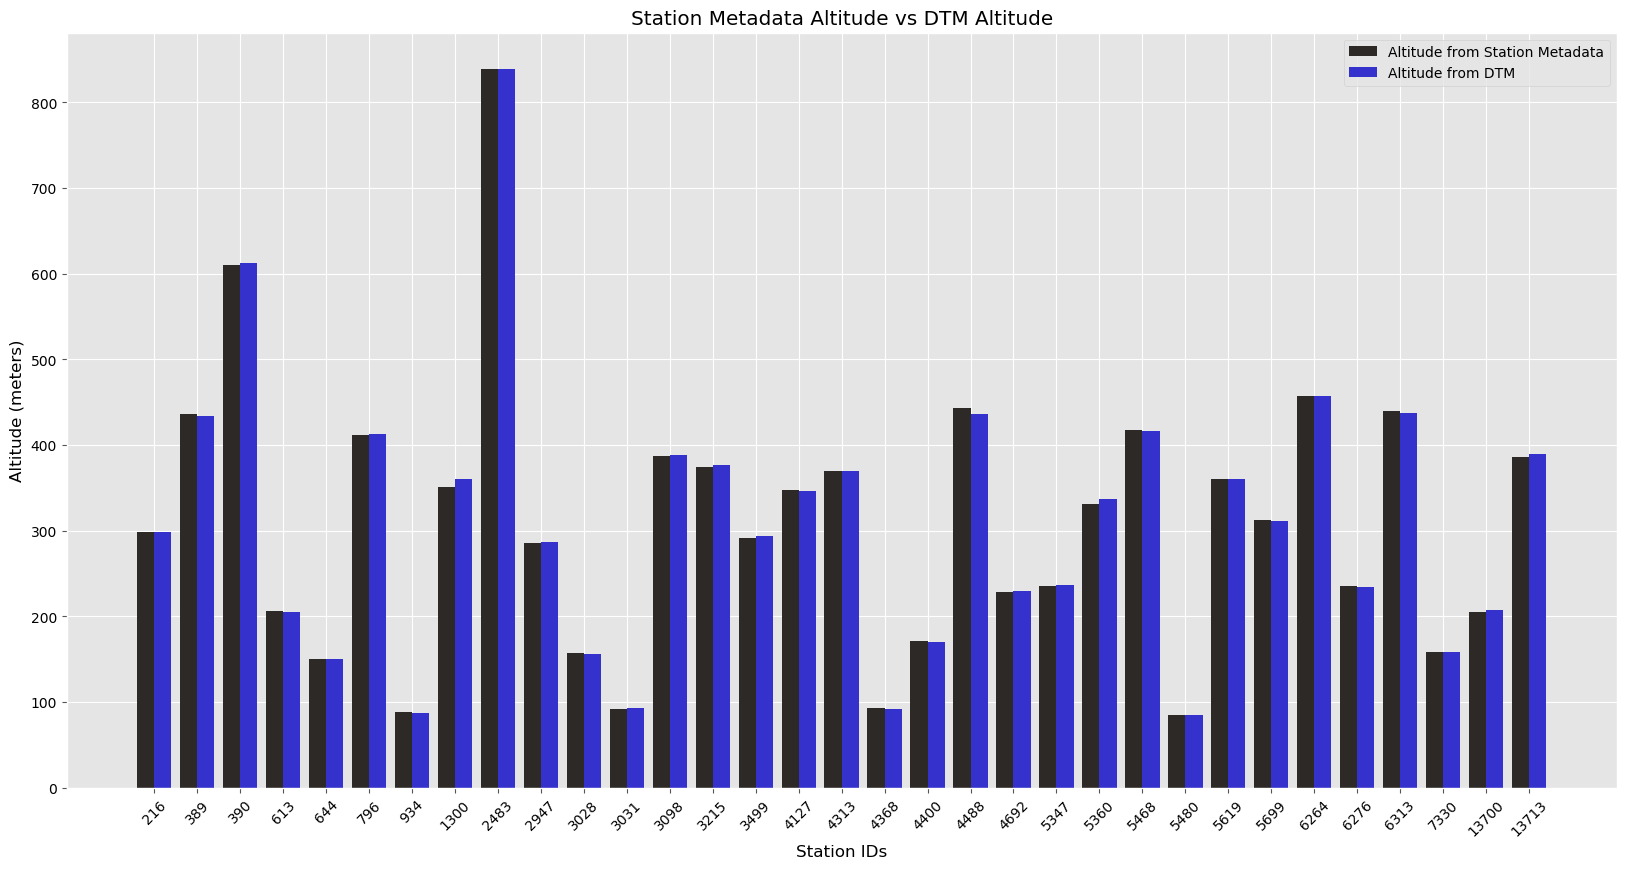

figure saved at ../data/generated/DWD//hourly/precipitation/historical/


In [63]:
w = 0.4
fig = plt.figure(dpi= 100,figsize=(20,10))
plt.style.use('ggplot')

bar1 = np.arange(len(dtmdata['station_id']))
bar2 = [i+w for i in bar1]

plt.bar(bar1,dtmdata['altitude'],w,label='Altitude from Station Metadata',color='#2D2926FF')
plt.bar(bar2,dtmdata['rvalue_1'],w,label='Altitude from DTM',color='#3531CD')

plt.xlabel('Station IDs',color='black')
plt.ylabel('Altitude (meters)',color='black')
plt.title('Station Metadata Altitude vs DTM Altitude',color='black')
plt.xticks(bar1+w/2,dtmdata['station_id'],rotation=45,color='black')
plt.yticks(color='black')
plt.legend()
plt.show()

fig.savefig(local_station_dir + 'station_alt_vs_DTM_alt.png' , dpi = 200)
print("figure saved at " + local_station_dir )